# Rozdzielczość obrazu. Interpolacja.

## Cel zajęć:

* zapoznanie z pojęciem rozdzielczości przestrzennej (rozmiaru obrazu),
* metody interpolacji najbliższego sąsiada oraz dwuliniowa,
* zapoznanie z pojęciem rozdzielczości dpi (ang. dots per inch),
* zapoznanie z pojęciem rozdzielczości  poziomów jasności (dla obrazów w skali szarości),
* zadanie domowe: interpolacja dwusześcienna.

## Rodzielczość przestrzenna

Dyskretna reprezentacja obrazu to zwykle macierz dwu (N x M - obraz w skali szarości) lub trójwymiarowa (N x M x 3 - obraz kolorowy).
Przez rozdzielczość przestrzenną rozumie się liczbę pikseli z których składa się obraz.
Przykładowo rozdzielczość VGA to  640 x 480, Full HD to 1920 x 1080, a 4K to 3840 x 2160.
Rozdzielczość obrazu można modyfikować (zwiększać/zmniejszać), co nazywa się skalowaniem obrazu.
Warto wiedzieć, że zwiększenie rozdzielczości obrazu nie zwiększa ilości informacji, a jedynie liczbę pikseli (w sensie "lepiej nie będzie").
Ponadto skalowanie zawsze wprowadza pewne zniekształcenia, nawet przy zmniejszaniu rozmiaru.

W ramach niniejszego ćwiczenia zapoznamy się z metodami interpolacji, które są podstawą takich operacji jak: przybliżanie (zoom), zmiana rozdzielczości, rotacja obrazu, czy też korekcje geometryczne.
Jako przykład posłuży nam zmiana rozdzielczości, czyli inaczej mówiąc przepróbkowanie obrazu.
Dla przypomnienia - interpolacja to wykorzystanie znanych danych (wartości dla tzw. punktów węzłowych) do określania wartości w nieznanych lokalizacjach.

Zacznijmy od prostego przykładu.
Mamy obraz o rozdzielczości 500 x 500 pikseli, a chcemy go powiększyć do 750 x 750 pikseli -- tj. o współczynnik 1,5.
Wyobraźmy sobie zatem, że dysponujemy siatką 750 x 750 o takim samym "rozmiarze" pojedynczego piksela jak obraz oryginalny.
Następnie siatkę tą ,,ścieśniamy'', tak aby miała rozmiar 500 x 500.
W rezultacie otrzymana siatka będzie miała mniejszy rozmiar pojedynczego piksela niż obraz oryginalny.
Schematycznie przedstawiono to na poniższym rysunku.

![Ilustracja interpolacji](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interEx57.png)


Pokazuje on przykład interpolacji: a) obraz 5x5, b) oraz 7x7, c) obraz 7x7 zmiejszony do 5x5.


Chcemy teraz poszczególnym elementom nowej siatki przyporządkować piksele z obrazu wejściowego.
Jedną z możliwości jest poszukanie "najbliższego" piksela w oryginalnym obrazie i wzięcie jego wartości.
Przykład takiego postępowania zaprezentowano na  poniższym rysunku.

![Ilustracja najbliższego sąsiada](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/inteNNEx.png)

Kilka słów wyjasnienia.
Kolorem ciemnoszarym oznaczono siatkę 5x5, a czarnym 7x7 (już po przeskalowaniu).
Nasze zadanie sprowadza się do zalezienia dla każdej kropki czarnej (umowny środek piksela), najbliżej leżącej kropki szarej - oznaczono to dla pierwszych trzech wierzszy obrazu liniami.

Po zrealizowaniu powyższego kroku dla całego obrazu wykonujemy "rozciągniecie" do rozdzielczości 750 x 750.
W ten sposób uzyskujemy finalny efekt zmiany rozdzielczości.

## Interpolacja metodą najbliższego sąsiada

Takie postępowanie określa się mianem **interpolacji metodą najbliższego sąsiada** (ang. *nearest neighbour interpolation*).
W ramach pierwszego etapu ćwiczenia zaimplementujemy to podejście.

1. Ładujemy potrzebne biblioteki, pobieramy obrazy z repozytorium, wczytujemy jeden z obrazów testowych (*parrot.bmp*) i wyświetlamy go:

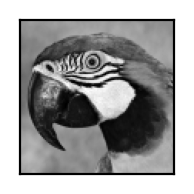

In [3]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/'

fileNames = ["parrot.bmp", "clock.bmp", "chessboard.bmp", "bart.png", "firetruck.jpg"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)


I = cv2.imread('parrot.bmp')           # Read image
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY) # Convert to RGB

# Display
plt.figure(figsize=(I.shape[0]/100,I.shape[1]/100), dpi=200)
plt.imshow(I, cmap ="gray")
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

2. Definiujemy funkcję do interpolacji metodą najbliższego sąsiada.

Jako argumenty wejściowe powinna ona przyjąć obraz oraz współczynniki skalowania w pionie i poziomie.
Wyjściem powinien być natomiast obraz w nowej rozdzielczości.
Wewnątrz należy:

* odczytać wymiary obrazka wejściowego,
* wyliczyć wymiary obrazka wyjściowego (tj. wymnożyć wymiary wejściowe przez skalę i zaokrąglić do liczb całkowitych),
* utworzyć nowy obraz o ww. rozmiarze,
* w pętli po nowym obrazie, dla każdego piksela, wykorzystując współczynniki skalowania, odnaleźć najbliższego sąsiada.




In [77]:
# def scale(img, h_scale, v_scale):
#     height, width = img.shape

#     new_width = int(width * h_scale)
#     new_height = int(height * v_scale)

#     new_img = np.zeros((new_height, new_width), np.uint8)

#     for i in range(new_height):
#         for j in range(new_width):
#             if (i / v_scale) < height - 1 and (j / h_scale) < width - 1:
#                 new_img[i, j] = img[round(i / v_scale), round(j / h_scale)]

#     return new_img

import math

def scale(img, h_scale, v_scale):
    height, width = img.shape

    new_width = int(width * h_scale)
    new_height = int(height * v_scale)
    
    new_img = np.zeros((new_height, new_width), np.uint8)

    for i in range(new_height):
        for j in range(new_width):
                orig_i = round(i / v_scale)
                orig_j = round(j / h_scale)

                # E.g. 249th pixel / 2.5 = 99.6, but should be 99th pixel
                if orig_i >= height:
                    orig_i = height - 1
                if orig_j >= width:
                    orig_j = width - 1

                new_img[i, j] = img[orig_i, orig_j]

    return new_img

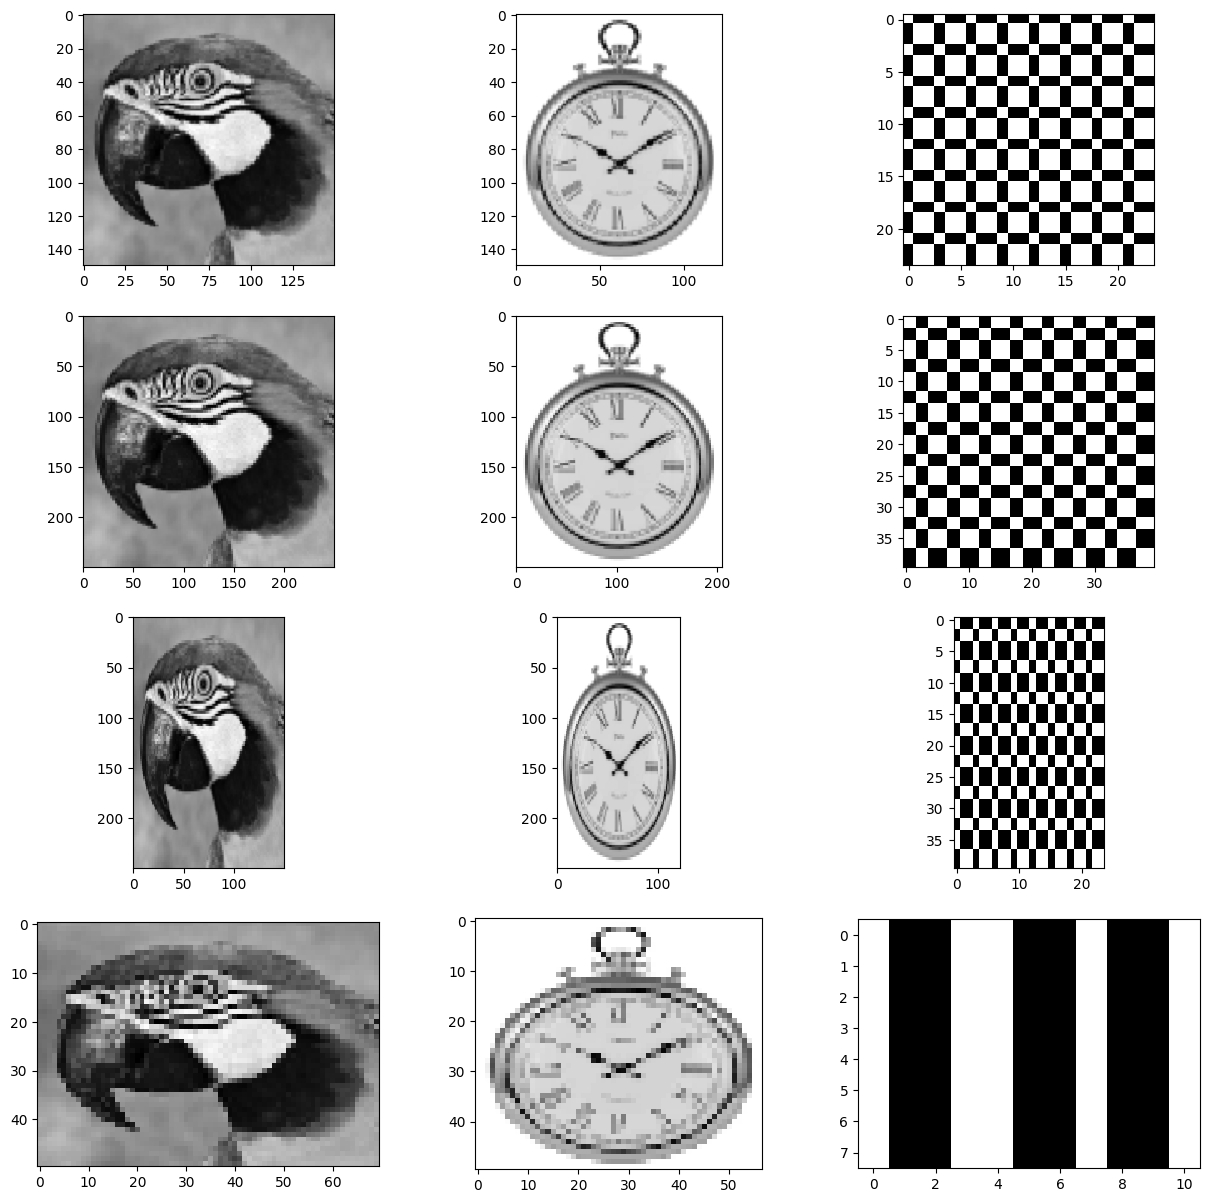

In [78]:
scale_factors = [(1.5, 1.5), (2.5, 2.5), (1.5, 2.5), (0.7, 0.5)]
imgs = ['parrot.bmp', 'clock.bmp', 'chessboard.bmp']

fig, axs = plt.subplots(4, 3, figsize=(15, 15))

row = 0
col = 0
for img_name in imgs:
    for scale_factor in scale_factors:
        img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        img = scale(img, scale_factor[0], scale_factor[1])
        axs[row, col].imshow(img, cmap='gray')
        plt.imshow(img, cmap='gray')
        row += 1
    col += 1
    row = 0

3. Testujemy stworzoną funkcję:
    * dla skali 1.5, 1.5 i obrazka *parrot*,
    * dla 2.5, 2.5 - tu może okazać się, że do kodu trzeba dopisać zabezpieczenie przed wyjściem poza zakres,
    * dla niejednakowych skal np. 1.5 i 2.5,
    * dla skal mniejszych od 1,
    * dla niesymetrycznego obrazka *clock*,
    * dla obrazka z szachownicą *chessboard*.

Uwaga: proszę dla powyższych przypadków przygotować osobne sekcje kodu - tak, aby wyświetlały się wszystkie rozważane przypadki.

Wykonana metoda jest bardzo prosta i szybka, ale wprowadza pewne niepożądane artefakty, w szczególnie źle odwzorowane są linie proste.
Z drugiej strony sprawdza się w pewnych nietypowych przypadkach.
Zostanie to zademonstrowane w dalszej części ćwiczenia.

## Interpolacja dwuliniowa

W praktyce, lepszym rozwiązaniem zwykle okazuje tzw. **interpolacja dwuliniowa** (ang. *bilinear interpolation*).
Wykorzystuje ona informację o czterech najbliższych sąsiadach do określenia nowej wartości piksela.

Jeśli przez $(i,j)$ oznaczymy współrzędne poszukiwanego piksela, a przez $I(i,j)$ jego jasność (składową w odcieniach szarości) to jego wartość można obliczyć wykorzystując równanie:
\begin{equation}
I(i,j) = a \cdot i + b \cdot j+ c \cdot i \cdot j + d
\end{equation}
gdzie: współczynniki $a,b,c,d$ można wyliczyć na podstawie czterech najbliższych sąsiadów.

![Ilustracja dwuliniowej](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interABCD.png)

Prześledźmy to na przykładzie z powyższego rysunku.
Niech współrzędne poszczególnych punktów to $A = (j_1,i_1)$, $B = (j_1,i_2)$, $ C= (j_2,i_2)$ oraz $D = (j_2,i_1)$.
W pierwszej kolejności dokonujemy interpolacji wartości w punktach $AB$ i $CD$ -- czyli poziomo.
Wychodząc od równania prostej otrzymujemy:

\begin{equation}
f(AB) \approx \frac{i_2 - i}{i_2-i_1}f(A) + \frac{i - i_1}{i_2-i_1}f(B)
\end{equation}

\begin{equation}
f(CD) \approx \frac{i_2 - i}{i_2-i_1}f(D) + \frac{i - i_1}{i_2-i_1}f(C)
\end{equation}

Następnie wykonujemy analogiczną interpolację w pionie:
\begin{equation}
f(ABCD) \approx \frac{j_2 - j}{j_2-j_1}f(AB) + \frac{j - j_1}{j_2-j_1}f(CD)
\end{equation}

Łącząc powyższe równania otrzymujemy:
\begin{equation}
f(ABCD) \approx \frac{1}{(i_2 - i_1)(j_2-j_1)} ( f(A)(i_2-i)(j_2 - y) + f(B)(i-i_1)(j_2 - j) \\ + f(C)(i-i_1)(j-j_1) + f(D)(i_2-i)(j-j_1))
\end{equation}
gdzie zapis $f(X)$ oznacza wartość piksela w punkcie $X$.

Rozważania można uprościć przyjmując, że narożniki rozpatrywanego kwadratu mają następujące współrzędne: $A = (0,0)$, $B = (0,1)$, $ C= (1,1)$ oraz $D = (1,0)$.
Wtedy powyższe równanie można zapisać:
\begin{equation}
f(ABCD) \approx f(A)(1-i)(1-j) + f(B)i(1-j) + f(C)ij + f(D)(1-i)j
\end{equation}

lub macierzowo:
\begin{equation}
f(ABCD) \approx \begin{bmatrix}1 - i & i \end{bmatrix} \begin{bmatrix} f(A) & f(D) \\\\ f(B) & f(C)  \end{bmatrix}   \begin{bmatrix} 1-j \\\\ j  \end{bmatrix}
\end{equation}

Uwaga.
Nieco wbrew nazwie interpolacja dwuliniowa nie jest operacją liniową.
W złożeniu dwóch operacji liniowych pojawia się człon $xy$.

Warto dodać, że kolejny ``poziom wtajemniczenia'' to **interpolacja dwusześcienna** (ang. *bicubic interpolation*).
Dana jest ona wzorem:
\begin{equation}
I(i,j) = \sum_{i=0}^{3} \sum_{j=0}^{3} a_{ij} x^i y^j
\end{equation}
Jej implementacja stanowi zadanie domowe do bieżącego ćwiczenia.

Trzy powyżej przedstawione metody bynajmniej nie wyczerpują tematu.
Wystarczy choćby otworzyć stronę [wiki o skalowaniu](https://en.wikipedia.org/wiki/Image_scaling), by zobaczyć, że metod jest dużo więcej.



Wykorzystując powyższe równania zaimplementuj interpolację dwuliniową:
* dobrym punktem wyjścia będzie stworzona funkcja do interpolacji metodą najbliższego sąsiada,
* początek powinien być identyczny,
* różnice rozpoczynają się w momencie obliczenia współrzędnych nowego piksela,
* jeśli chcemy zastosować opisane powyżej wzory (w wariancie uproszczonym), to musimy wyliczyć współrzędne punktów $A,B,C,D$,
* w pierwszym kroku obliczamy współrzędne $A$ tj. $(0,0)$ - należy do tego wykorzystać funkcję *floor* (np. $i_1 = floor(i / h_{scale})$).
  Proszę ten krok odnieść do przedstawionego rysunku poglądowego,
* obliczenie współrzędnych $B,C,D$ jest już proste i sprowadza się do operacji `+1`,
* potrzebujemy jeszcze część ułamkową współrzędnych punktu $ABCD$ tj. $(i,j)$ - od ilorazu $i/h_{scale}$ należy odjąć wartość $i_1$
* wykorzystując wyznaczone współrzędne, należy pobrać wartości jasności w punktach $A,B,C,D$, tj. $f(A),f(B),f(C),f(D)$, podstawić do odpowiedniego równania i wykonać interpolację.

  Uwagi:
* Tworzenie macierzy *np.array*, mnożenie macierzy *np.dot*. Przy tworzeniu macierzy proszę zwrócić uwagę na niezbędne nawiasy kwadratowe.
* Przy próbie uruchomienia kodu pewnie okaże się, że wystąpi przekroczenie zakresu - należy dodać stosowne zabezpiczenie.

Proszę dla interpolacji dwuliniowej wykonać takie same eksperymenty, jak dla  najbliższego sąsiada.




\begin{equation}
f(ABCD) \approx f(A)(1-i)(1-j) + f(B)i(1-j) + f(C)ij + f(D)(1-i)j
\end{equation}

\begin{equation}
f(ABCD) \approx \begin{bmatrix}1 - i & i \end{bmatrix} \begin{bmatrix} f(A) & f(D) \\\\ f(B) & f(C)  \end{bmatrix}   \begin{bmatrix} 1-j \\\\ j  \end{bmatrix}
\end{equation}

![Ilustracja dwuliniowej](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interABCD.png)

In [ ]:
print(149 / 1.5)

99.33333333333333


In [87]:
import math

def interpolate(img, h_scale, v_scale):
    height, width = img.shape

    new_width = int(width * h_scale)
    new_height = int(height * v_scale)

    new_img = np.zeros((new_height, new_width), np.uint8)

    for i in range(new_width):
        for j in range(new_height):

            # where the pixel is located in the original image
            original_i = i / h_scale
            original_j = j / v_scale

            # handle the situation when "next pixel" is out of bounds
            if original_j >= height - 1:
                original_j = height - 2
            if original_i >= width - 1:
                original_i = width - 2
                
            # implemented operations
            A = (math.floor(original_j), math.floor(original_i))
            B = (A[0], A[1] + 1)
            C = (A[0] + 1, A[1] + 1)
            D = (A[0] + 1, A[1])

            frac_i = original_i - A[1]
            frac_j = original_j - A[0]

            A_lightness = img[A[0], A[1]]
            B_lightness = img[B[0], B[1]]
            C_lightness = img[C[0], C[1]]
            D_lightness = img[D[0], D[1]]

            corner_values = np.array([[A_lightness, D_lightness],
                                      [B_lightness, C_lightness]])

            weights_i = np.array([1 - frac_i, frac_i])
            weights_j = np.array([[1 - frac_j], [frac_j]])

            ABCD_lightness = weights_i @ corner_values @ weights_j

            new_img[j, i] = ABCD_lightness

    return new_img


C:\Users\Bartek\AppData\Local\Temp\ipykernel_12460\80369945.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_img[j, i] = ABCD_lightness


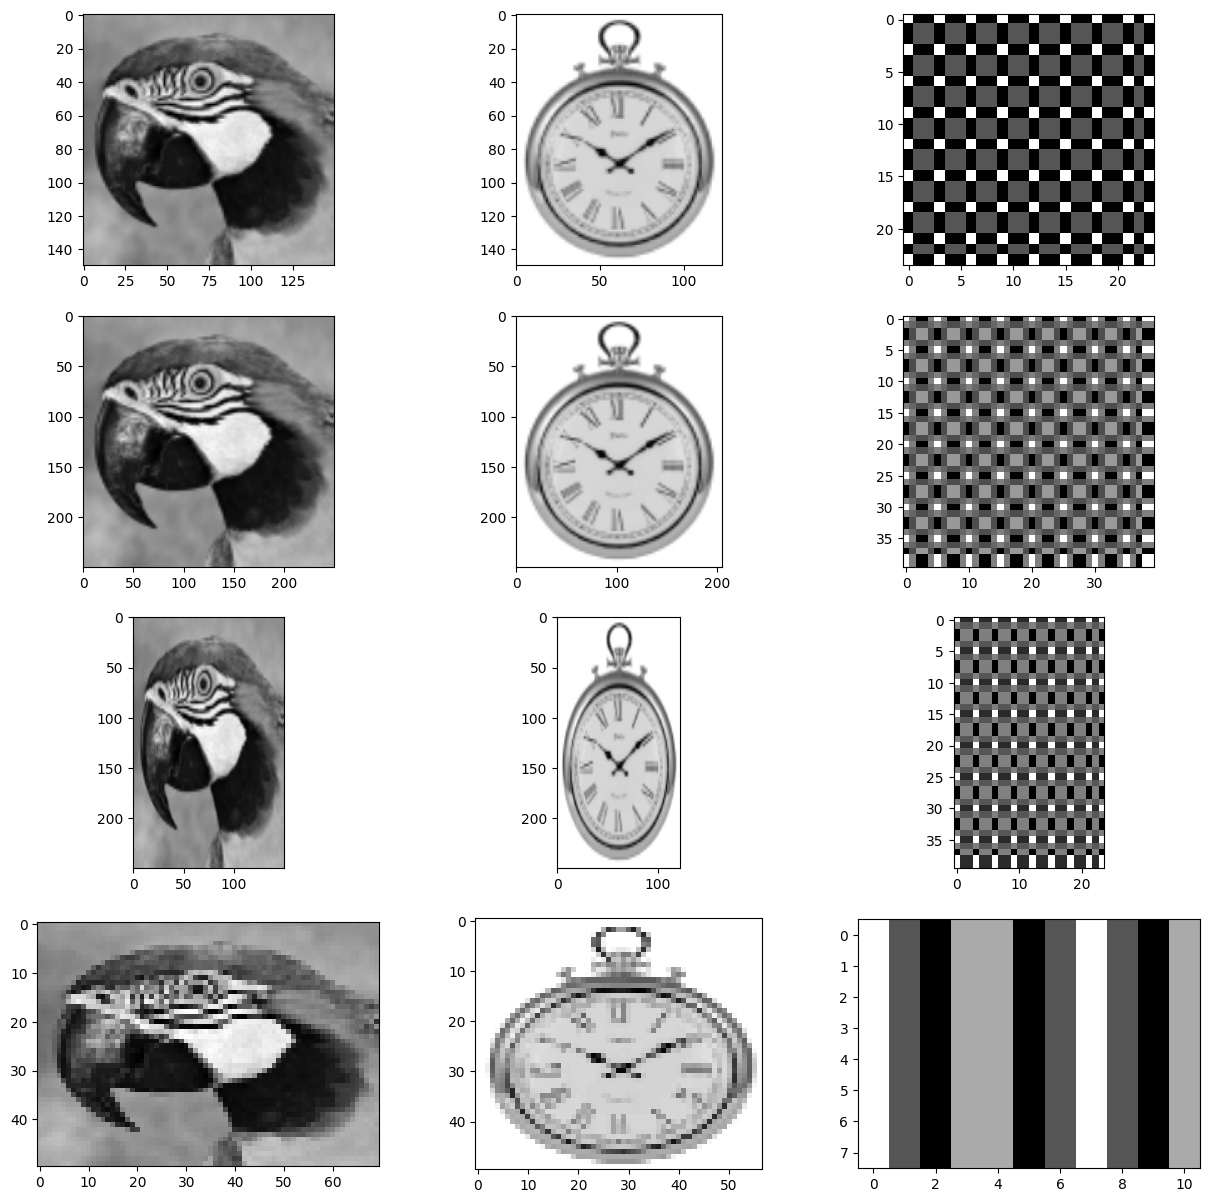

In [88]:
scale_factors = [(1.5, 1.5), (2.5, 2.5), (1.5, 2.5), (0.7, 0.5)]
imgs = ['parrot.bmp', 'clock.bmp', 'chessboard.bmp']

fig, axs = plt.subplots(4, 3, figsize=(15, 15))

row = 0
col = 0
for img_name in imgs:
    for scale_factor in scale_factors:
        img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        img = interpolate(img, scale_factor[0], scale_factor[1])
        axs[row, col].imshow(img, cmap='gray')
        plt.imshow(img, cmap='gray')
        row += 1
    col += 1
    row = 0


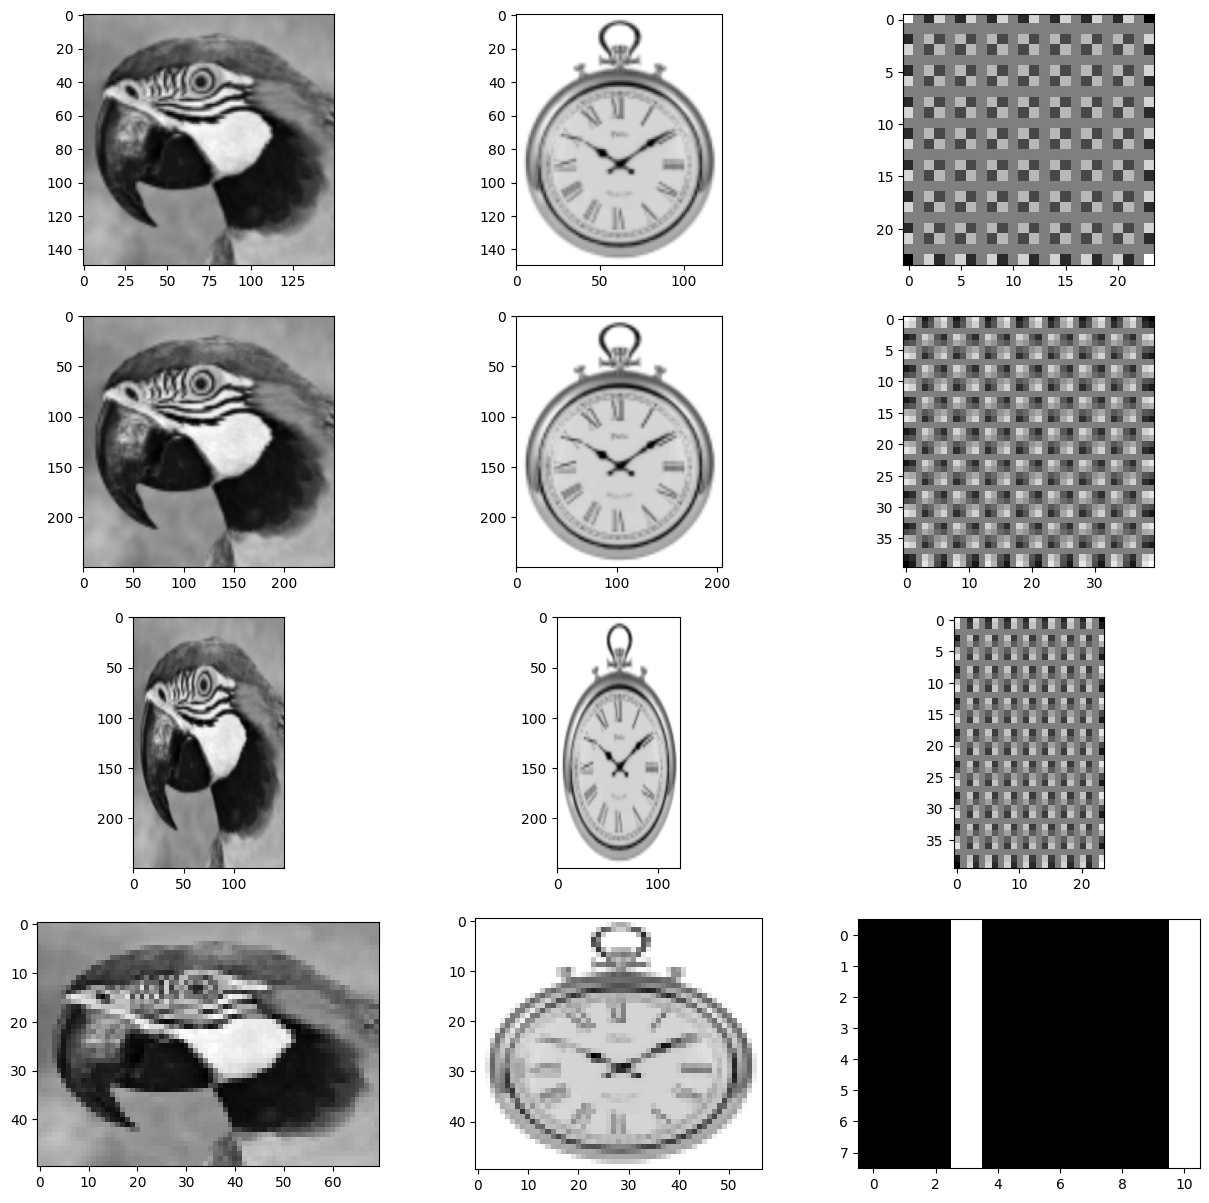

In [ ]:
scale_factors = [(1.5, 1.5), (2.5, 2.5), (1.5, 2.5), (0.7, 0.5)]
imgs = ['parrot.bmp', 'clock.bmp', 'chessboard.bmp']

fig, axs = plt.subplots(4, 3, figsize=(15, 15))

row = 0
col = 0
for img_name in imgs:
    for scale_factor in scale_factors:
        img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, None, fx=scale_factor[0], fy=scale_factor[1], interpolation=cv2.INTER_LINEAR)
        axs[row, col].imshow(img, cmap='gray')
        plt.imshow(img, cmap='gray')
        row += 1
    col += 1
    row = 0


## Intepolacja w OpenCV

W OpenCV dostępna jest funkcja `resize`, która służy do zmiany rozmiaru obrazka.
Składnia jest następująca `dst = cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]] )`, gdzie `dst` to obraz wynikowy, `src` obraz źródłowy, `dsize` rozmiar docelowy (ew. można podać współczynniki skalowania dla poszczególnych osi: `fx,fy`), `interpolation` metoda interpolacji.
Metod podstawowych dostępnych jest 5:
- najbliższego sąsiada - ` cv2.INTER_NEAREST`,
- dwuliniowa - ` cv2.INTER_LINEAR`,
- dwukubiczna - ` cv2.INTER_CUBIC`,
- *area* - ` cv2.INTER_AREA`,
- *lanczos4* - ` cv2.INTER_LANCZOS4`.

Przeprowadzimy następujący eksperyment: obraz (o większej niż dotąd rozdzielczości) przeskalujemy każdą z metod -- zwiększymy i zmniejszymy jego rozdzielczość. Dodamy też pomiar czasu realizacji obliczeń.

Proszę stworzyć funkcję, która jako argumenty przyjmuje obraz oraz dwa współczynniki skalujące, a wewnątrz przeprowadzone zostaną interpolacje, pomiar czasu oraz wizualizacja (można wypisać czas w tytule rysunku).

Pomiar czasu:
```{python}
from timeit import default_timer as timer
start = timer()
# ...
end = timer()
print(end - start)
```

Wykonaj eksperyment dla kilku różnych skal, przeanalizuj czasy obliczeń.

In [ ]:
from timeit import default_timer as timer
import textwrap

def benchmark(img, h_scale, v_scale, interpolation):
    start = timer()

    img = cv2.resize(img, None, fx=h_scale, fy=v_scale, interpolation=interpolation)

    end = timer()

    return end - start, img

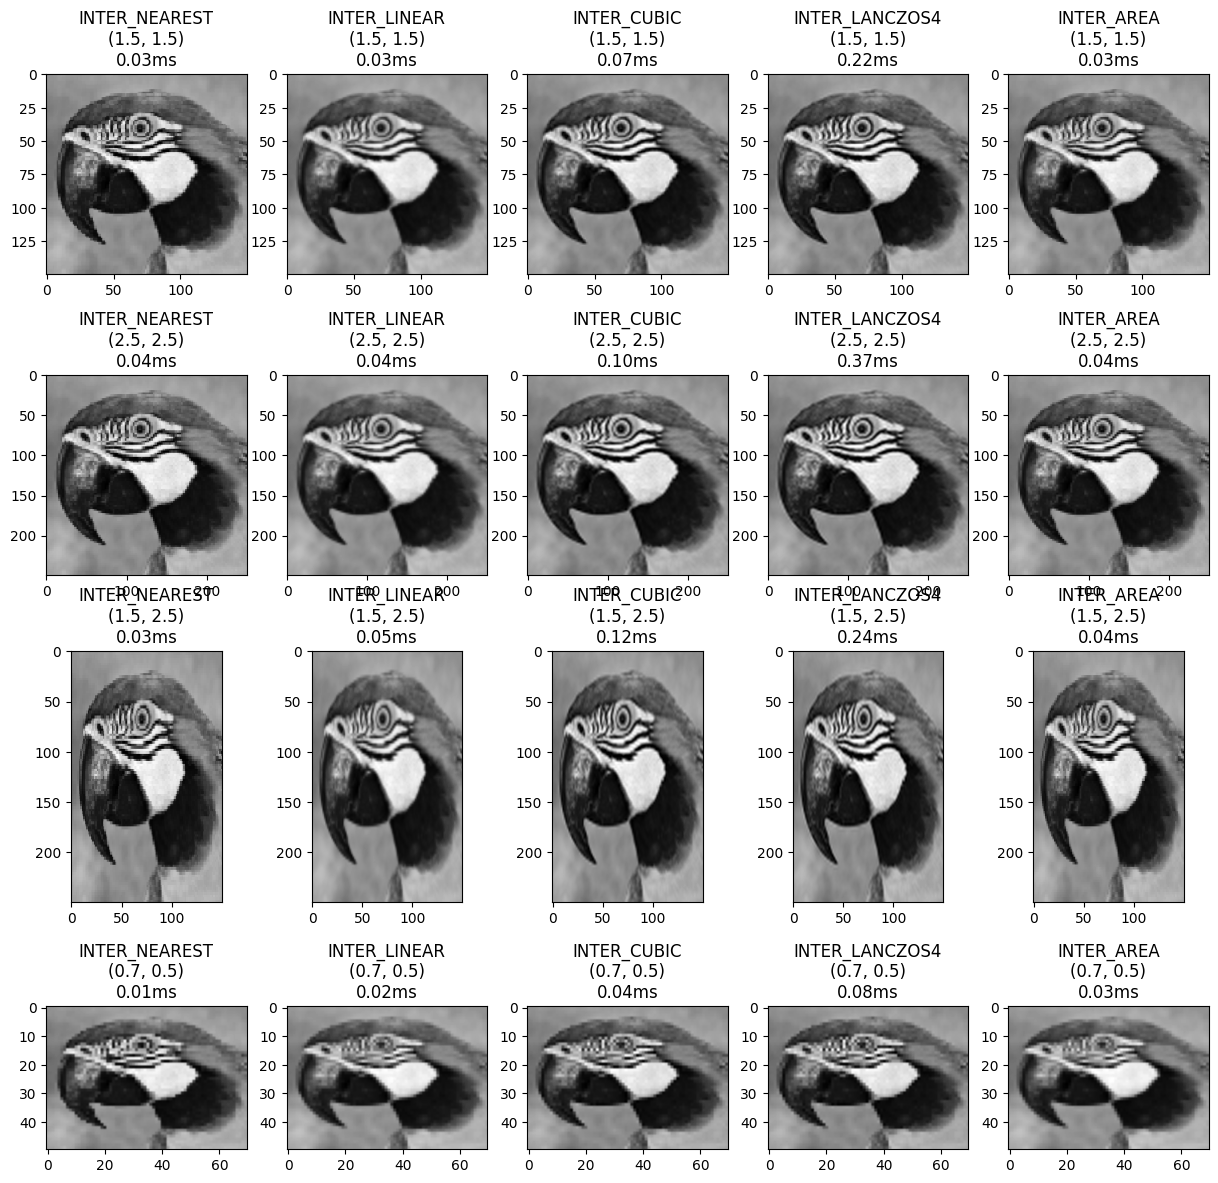

In [ ]:
scale_factors = [(1.5, 1.5), (2.5, 2.5), (1.5, 2.5), (0.7, 0.5)]
interpolations = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_LANCZOS4, cv2.INTER_AREA]

fig, axs = plt.subplots(4, 5, figsize=(15, 15))

interpolation_names = {
    cv2.INTER_NEAREST: "INTER_NEAREST",
    cv2.INTER_LINEAR: "INTER_LINEAR",
    cv2.INTER_CUBIC: "INTER_CUBIC",
    cv2.INTER_LANCZOS4: "INTER_LANCZOS4",
    cv2.INTER_AREA: "INTER_AREA"
}

row = 0
col = 0
for interpolation in interpolations:
    for scale_factor in scale_factors:
        img = cv2.imread('parrot.bmp', cv2.IMREAD_GRAYSCALE)
        time, img = benchmark(img, scale_factor[0], scale_factor[1], interpolation)
        axs[row, col].imshow(img, cmap='gray')
        title_text = f'{interpolation_names[interpolation]} {scale_factor} {time * 1000:.2f}ms'
        wrapped_title = textwrap.fill(title_text, width=15)
        axs[row, col].set_title(wrapped_title)
        plt.imshow(img, cmap='gray')
        row += 1
    col += 1
    row = 0

## Rozdzielczość (dpi)

Omówioną wcześniej rozdzielczość przestrzenną (rozmiar) należy utożsamiać z rozmiarem macierzy w której zapisany jest obraz.
W tym ujęciu rozmiar pojedynczego piksela nie ma specjalnego znaczenia.
Problem pojawia się, kiedy obraz trzeba wyświetlić lub wydrukować.
Wtedy pojedynczy piksel staje się ,,obiektem fizycznym'' i musi mieć swój rozmiar (wysokość/szerokość/powierzchnię).

Parametr dpi (ang. *dots per inch*) określa liczbę kropek (pikseli), która mieści się na jednym calu (25,4 mm) długości/szerokości.
Dopiero kombinacja rozmiaru i rozdzielczości określa nam rzeczywisty rozmiar obrazu jaki uzyskamy na wydruku.

Dpi staje się istotne w przypadku drukowania, gdyż wyświetlanie na monitorze odbywa się zazwyczaj 1 piksel obrazka = 1 piksel na monitorze (w przypadku maksymalnej rozdzielczości wspieranej przez monitor), ew. następuje automatyczne skalowanie.

Wpływ rozdzielczości można zademonstrować w następujący sposób:
- wczytaj obraz *lena.bmp*.  Ma on rozmiar $512 \times 512$.
- wykorzystując funkcję `imresize` stwórz obrazy o rozmiarach $256 \times 256$, $128 \times 128$, $64 \times 64$ - metoda interpolacji jest w tym wypadku mniej istotna.
- wyświetl obrazy wymuszając zachowanie na ekranie wejściowej rozdzielczości $512 \times 512$. W przypadku biblioteki *matplotlib* ta funkcjonalność jest domyślna.

Proszę zaobserwować co dzieję się z obrazkiem.

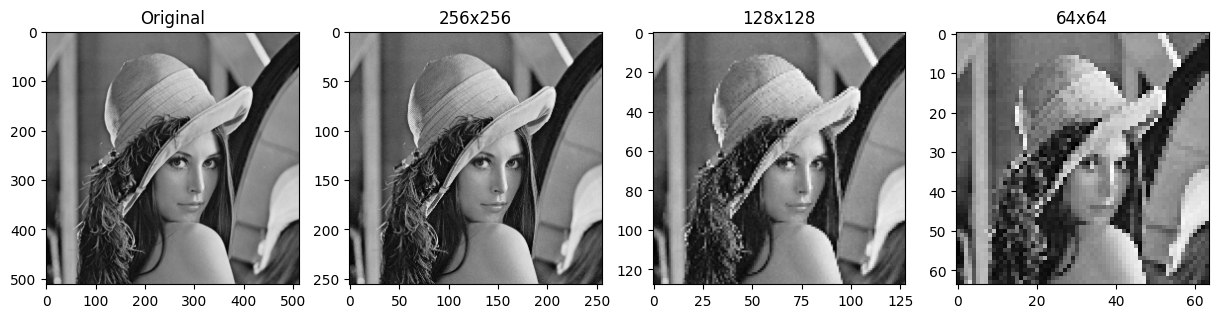

In [ ]:
#TODO Porównanie
img = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)

img1 = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img2 = cv2.resize(img, (128, 128), interpolation=cv2.INTER_NEAREST)
img3 = cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)

fig, axs = plt.subplots(1, 4, figsize=(15, 15))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(img1, cmap='gray')
axs[1].set_title('256x256')
axs[2].imshow(img2, cmap='gray')
axs[2].set_title('128x128')
axs[3].imshow(img3, cmap='gray')
axs[3].set_title('64x64')
plt.show()

## Liczba poziomów jasności

Dla obrazów w skali szarości pojedynczy piksel zwykle zapisuje się na 8 bitach, co daje 256 rozróżnialnych poziomów szarości.
Dla większości zastosowań wartość ta jest wystarczająca (choć są kamery o wyjścu 12 lub 16 bitów).
Jednak oko ludzkie nie potrafi rozróżnić wszystkich 256 poziomów jasności (jest za mało czułe).
Zazwyczaj człowiek rozróżnia 20-30 poziomów szarości (to ile i jakie dokładnie rozróżnia, zależy od konkretnego oświetlenia sceny i cech osobniczych).

W poniższych krokach zademonstrujemy omówione zjawisko:
- wczytaj (użyj) obrazu _lena_,
- wykorzystując znaną funkcję `normalize` zmień liczbę poziomów szarości z 0-255 na:
    * 0-31
    * 0-15
    * 0-7
    * 0-3
    * 0-1 (binaryzacja)
- rezultaty wyświetl na wspólnym rysunku.

Podpowiedzi:
- trzeba przygotować tablice na obrazki np, `I_31 = np.zeros(I.shape,'uint8')`,
- prawidłowe użycie funkcji normalize `cv2.normalize(I,I_31,0,31,cv2.NORM_MINMAX)`,
- przykładowe wyświetlanie `axsHist[0,1].imshow(I, 'gray', vmin=0, vmax=31)`.

Czy rezultaty eksperymentu pasują do teorii o rozpoznawaniu przez człowieka ograniczonego zakresu poziomów jasności?
Wizualne porównanie których obrazów o tym świadczy?

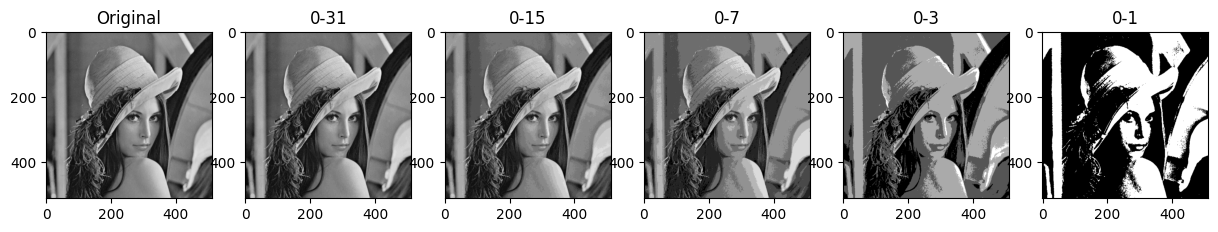

In [ ]:
I = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)

I_32 = np.zeros(I.shape, dtype=np.uint8)
cv2.normalize(I, I_32, 0, 31, cv2.NORM_MINMAX)

I_16 = np.zeros(I.shape, dtype=np.uint8)
cv2.normalize(I, I_16, 0, 15, cv2.NORM_MINMAX)

I_8 = np.zeros(I.shape, dtype=np.uint8)
cv2.normalize(I, I_8, 0, 7, cv2.NORM_MINMAX)

I_4 = np.zeros(I.shape, dtype=np.uint8)
cv2.normalize(I, I_4, 0, 3, cv2.NORM_MINMAX)

I_2 = np.zeros(I.shape, dtype=np.uint8)
cv2.normalize(I, I_2, 0, 1, cv2.NORM_MINMAX)

fig, axs = plt.subplots(1, 6, figsize=(15, 15))
axs[0].imshow(I, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(I_32, cmap='gray')
axs[1].set_title('0-31')
axs[2].imshow(I_16, cmap='gray')
axs[2].set_title('0-15')
axs[3].imshow(I_8, cmap='gray')
axs[3].set_title('0-7')
axs[4].imshow(I_4, cmap='gray')
axs[4].set_title('0-3')
axs[5].imshow(I_2, cmap='gray')
axs[5].set_title('0-1')
plt.show()